In [12]:
import jax

import jax.numpy as np
import numpy as np
import transforms3d as t3d

from scipy.spatial import KDTree
from tqdm import tqdm
from utils import read_canonical_model, load_pc, visualize_icp_result
from tools import sync_time_stamps

In [2]:
def Kabsch(m, z):
    # Kabsch algorithm
    # From m to z
    # z: source point cloud
    # m: target point cloud

    z_bar = np.mean(z, axis=0)
    m_bar = np.mean(m, axis=0)

    delta_z = (z - z_bar).reshape(len(z), 3, 1)
    delta_m = (m - m_bar).reshape(len(m), 3, 1)

    Q = np.zeros((3, 3))
    for i in range(len(z)):
        mult = delta_m[i] @ delta_z[i].T
        Q += mult

    # SVD
    U, s, Vt = np.linalg.svd(Q)
    det_UV = np.linalg.det(U @ Vt)
    mid_matrix = np.eye(3)
    mid_matrix[2][2] = det_UV

    R = U @ mid_matrix @ Vt
    p = m_bar - R @ z_bar

    return R, p

In [ ]:
# def ICP(z, m):
#     # ICP algorithm
#     # z: source point cloud
#     # m: target point cloud
#     # Transforming z into m
#     # i.e. finding the transformation from m to z
#     z = np.array(z)
#     m = np.array(m)

#     best_R, best_p = np.eye(3), np.zeros(3)

#     yaw_angles = np.linspace(-180, 180, 10)
#     min_err = np.inf

#     for yaw in tqdm(yaw_angles):
#         R_0 = t3d.euler.euler2mat(0, 0, np.radians(yaw))
#         p_0 = np.mean(m, axis=0) - np.mean(z, axis=0)

#         m_hat = (R_0 @ z.T).T + p_0
#         z_assoc = np.zeros_like(m)

#         for _ in range(50): 
#             # Associate points
#             tree = KDTree(m_hat)
#             dist, idx = tree.query(m)
#             z_assoc = z[idx]

#             R, p = Kabsch(m, z_assoc)

#             p = p.reshape(3)
#             m_hat = (R @ z.T).T + p

#             m_temp = (R @ z_assoc.T).T + p
#             err = np.sum(np.linalg.norm(m - m_temp, axis=1))

#             if err < min_err:
#                 min_err = err
#                 best_R = R
#                 best_p = p

#     return best_R, best_p

In [5]:
obj_name = 'drill' # drill or liq_container
num_pc = 4 # number of point clouds

source_pc = read_canonical_model(obj_name)

for i in range(num_pc):
    target_pc = load_pc(obj_name, i)
    R, p = ICP(source_pc, target_pc)

    # Estimated_pose, you need to estimate the pose with ICP
    pose = np.eye(4)
    pose[:3, :3] = R
    pose[:3, 3] = p

    # Visualize the estimated result
    visualize_icp_result(source_pc, target_pc, pose)

100%|██████████| 10/10 [00:14<00:00,  1.43s/it]
2025-02-23 23:58:03.191 python[27811:51276858] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-23 23:58:03.191 python[27811:51276858] +[IMKInputSession subclass]: chose IMKInputSession_Modern
100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


In [7]:
# Scan matching
dataset = 20
  
with np.load("../../data/Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

with np.load("../../data/Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]     # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans

    # Clipping the ranges
    lidar_ranges[lidar_ranges < lidar_range_min] = 0
    lidar_ranges[lidar_ranges > lidar_range_max] = 0
    lidar_ranges = lidar_ranges.T

with np.load("../../data/Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements

In [8]:
# Extracting point clouds from lidar data
def extract_pc(lidar_ranges, lidar_angle_increment):
    pc = []
    for i in range(len(lidar_ranges)):
        ranges = lidar_ranges[i]
        angles = np.arange(lidar_angle_min, lidar_angle_max + 1e-6, lidar_angle_increment)
        x = ranges * np.cos(angles)
        y = ranges * np.sin(angles)
        z = np.zeros_like(x)

        # Removing all zeros
        x = x[ranges != 0]
        y = y[ranges != 0]
        z = z[ranges != 0]
        pc.append(np.stack([x, y, z], axis=1))
    return pc

In [9]:
pc = extract_pc(lidar_ranges, lidar_angle_increment)
pose = np.eye(4)
# Visualize the estimated result
visualize_icp_result(pc[0], pc[0], pose)

/var/folders/1y/87vkwc9x32lcthv8n1nxqhz80000gn/T/ipykernel_27811/1867335340.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  angles = np.arange(lidar_angle_min, lidar_angle_max + 1e-6, lidar_angle_increment)


In [10]:
def velocity_right_encoder(counts, timestamps):
    delta_t = timestamps[1:] - timestamps[:-1]
    delta_t = [timestamps[1] - timestamps[0]] + list(delta_t)
    return ((counts[0, :] + counts[2, :]) / 2 * 0.0022) / delta_t

def velocity_left_encoder(counts, timestamps):
    delta_t = timestamps[1:] - timestamps[:-1]
    delta_t = [timestamps[1] - timestamps[0]] + list(delta_t)
    return ((counts[1, :] + counts[3, :]) / 2 * 0.0022) / delta_t

In [13]:
synced_encoder_stamps = sync_time_stamps(imu_stamps, encoder_stamps)

v_left = velocity_left_encoder(encoder_counts, encoder_stamps)
v_right = velocity_right_encoder(encoder_counts, encoder_stamps)

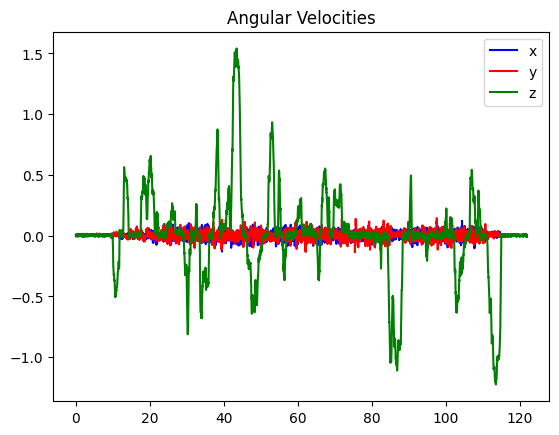

In [14]:
import matplotlib.pyplot as plt
# Plotting the x, y, z velocities
plt.title("Angular Velocities")
plt.plot(imu_stamps - imu_stamps[0], imu_angular_velocity[0], color='blue')
plt.plot(imu_stamps - imu_stamps[0], imu_angular_velocity[1], color='red')
plt.plot(imu_stamps - imu_stamps[0], imu_angular_velocity[2], color='green')
plt.legend(['x', 'y', 'z'])
plt.show()

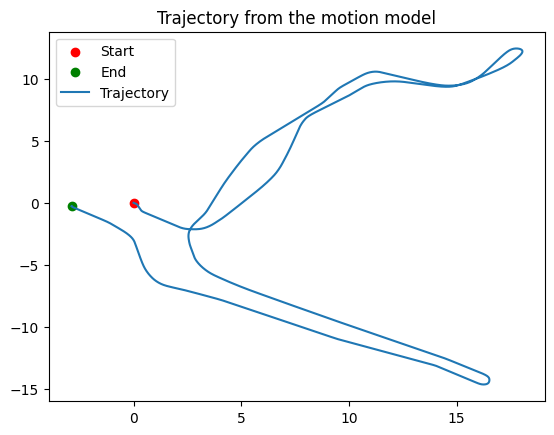

In [15]:
# Motion model
axel_length = 0.31115 # meters
wheel_diameter = 0.254 # meters

def motion_model(pose, v, omega, dt):
    x, y, theta = pose
    x += v * np.cos(theta) * dt
    y += v * np.sin(theta) * dt
    theta += omega * dt
    return np.array([x, y, theta])

pose = np.zeros((3))

x_traj = [0]
y_traj = [0]
poses = []

for i in range(len(imu_angular_velocity[2])):
    omega = imu_angular_velocity[2][i] # yaw angular velocity
    dt = imu_stamps[i] - imu_stamps[i - 1]
    encoder_ind = synced_encoder_stamps[i]
    v = (v_left[encoder_ind] + v_right[encoder_ind]) / 2
    pose = motion_model(pose, v, omega, dt)
    poses.append(pose)

poses = np.array(poses).T
# Beginning point
plt.scatter(0, 0, c='r')
# Ending point
plt.scatter(pose[0], pose[1], c='g')
plt.title("Trajectory from the motion model")
plt.plot(poses[0], poses[1])
plt.legend(["Start", "End", "Trajectory"])
plt.show()

In [31]:
from tools import ICP, Kabsch
# Using the ICP algorithm to estimate the pose initilized with the motion model
icp_poses = []
all_poses = []

init_pose = np.eye((4))
icp_poses.append(init_pose[:2, 3])

for i in tqdm(range(1, len(lidar_stamps))):
    imu_ind = synced_lidar_stamps[i]

    # Initial guesses
    x, y, theta = poses[:, imu_ind - 1] - poses[:, imu_ind ]

    R, p = ICP(pc[i], pc[i - 1], t3d.euler.euler2mat(0, 0, theta), np.array([x, y, 0]))

    dt = lidar_stamps[i] - lidar_stamps[i - 1]
    new_pose = np.eye(4)

    new_pose[:3, :3] = R
    new_pose[:3, 3] = p

    init_pose = init_pose @ new_pose
    
    all_poses.append(init_pose)
    icp_poses.append(init_pose[:2, 3])

icp_poses = np.array(icp_poses).T

100%|██████████| 4961/4961 [06:04<00:00, 13.62it/s]


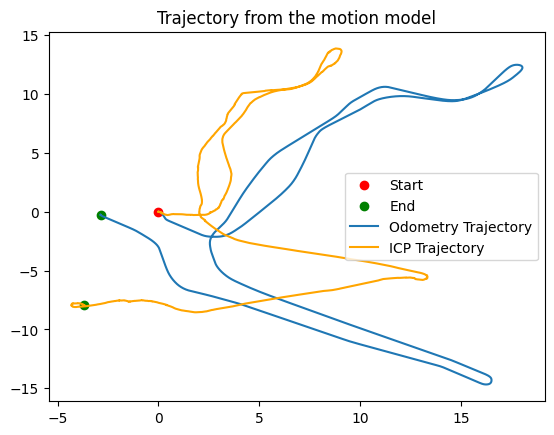

In [32]:
# Beginning point
plt.scatter(0, 0, c='red')
# Ending point
plt.scatter(pose[0], pose[1], c='green')
plt.title("Trajectory from the motion model")
plt.plot(poses[0], poses[1],)
plt.plot(icp_poses[0], icp_poses[1], c='orange')
plt.scatter(icp_poses[0, -1], icp_poses[1, -1], c='green')
plt.legend(["Start", "End", "Odometry Trajectory", "ICP Trajectory"])
plt.show()

In [23]:
# Saving the icp poses
np.save(f"icp_poses_{dataset}.npy", all_poses)